In [3]:
import sys
sys.path.insert(1, '../../ana_tools')
import getters, tools, graphic_tools, setters
import matplotlib.pyplot as plt
plt.style.use('../../ana_tools/presentation.mplstyle')
import numpy as np
path = "/eos/user/j/jcapotor/FBGana/camara_climatica/FebruaryRuns/"
plateaus = getters.get_plateaus()

/afs/cern.ch/user/j/jcapotor/FBG_TMS
/afs/cern.ch/user/j/jcapotor/FBG_TMS/ana_tools/plateaus.json


# RTD calibration

In [4]:
date = "20230227"
rtds = getters.get_raw_data(path_to_split=path+date+"/", filetype="temperature", pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
ids = {"T1":"37129", "T2":"39643", "T3":"39668", "T4":"40527", "T5":"44120", "T6":"39617"}

Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:03<00:00,  3.25s/it]


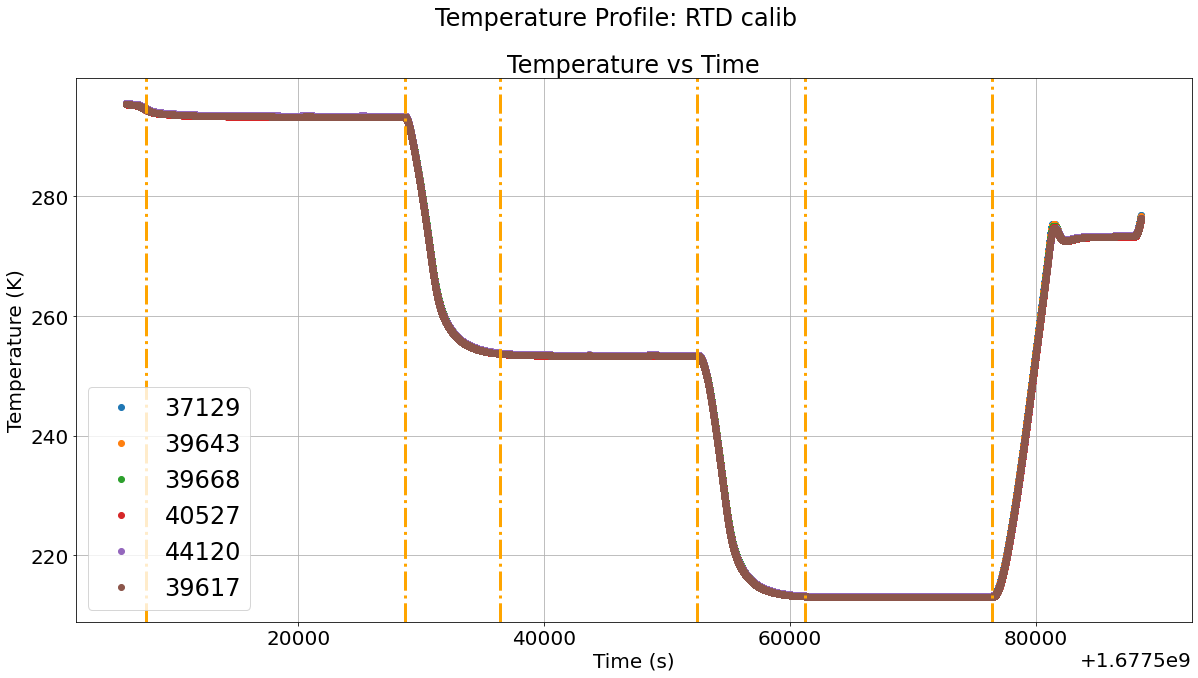

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches((20,10))
fig.suptitle("Temperature Profile: RTD calib")
for sens in rtds.columns:
    if sens == "Timestamp" or sens == "Time" or sens == "Date":
        continue
    axes.plot(rtds["Timestamp"], rtds[sens], "o", label=ids[sens])
axes.set_title("Temperature vs Time")
axes.set_xlabel("Time (s)")
axes.set_ylabel("Temperature (K)")
axes.legend(loc="lower left")
for plateau in plateaus[date]:
    t0 = plateaus[date][plateau][0]
    tf = plateaus[date][plateau][1]
    axes.axvline(t0, color="orange", linestyle="-.")
    axes.axvline(tf, color="orange", linestyle="-.")

/afs/cern.ch/user/j/jcapotor/.local/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/afs/cern.ch/user/j/jcapotor/.local/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/afs/cern.ch/user/j/jcapotor/.local/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/afs/cern.ch/user/j/jcapotor/.local/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/afs/cern.ch/user/j/jcapotor/.local/lib/python3.6/site-packages/ipykernel_launcher.p

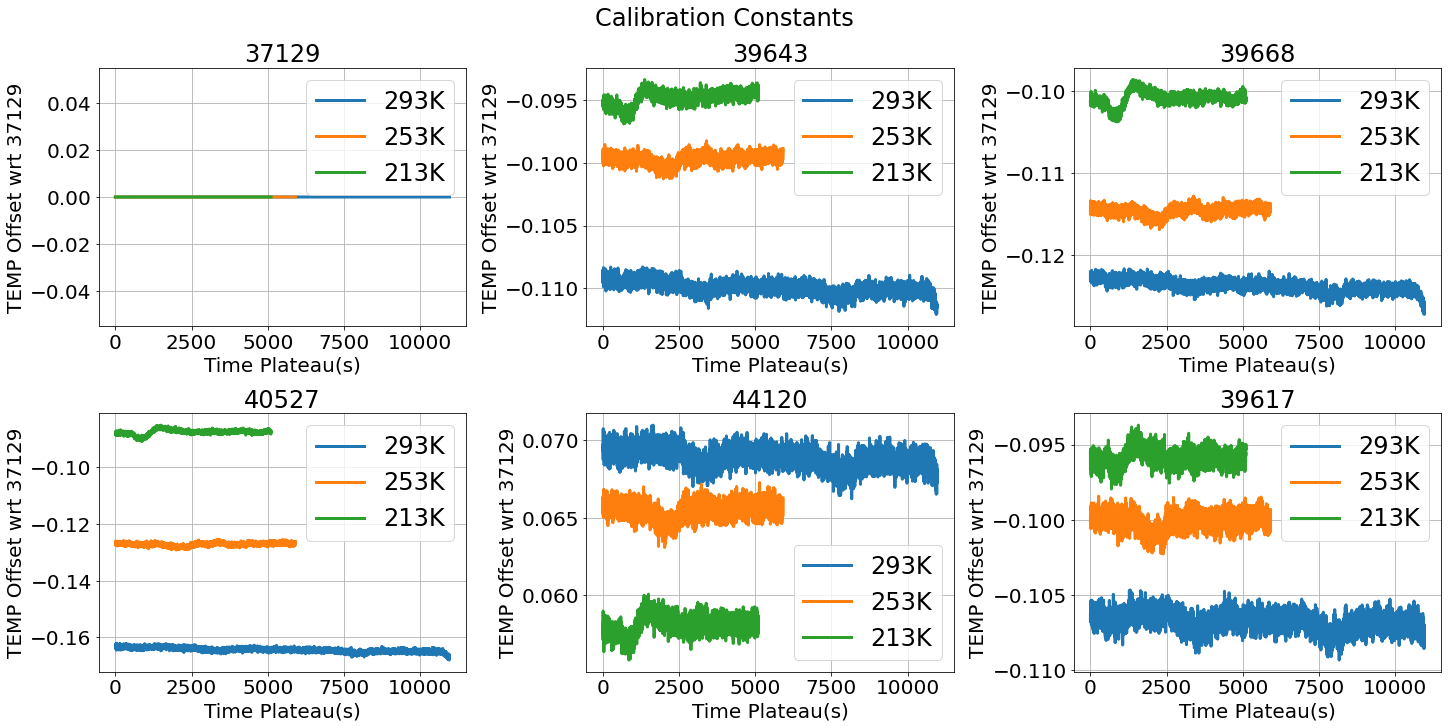

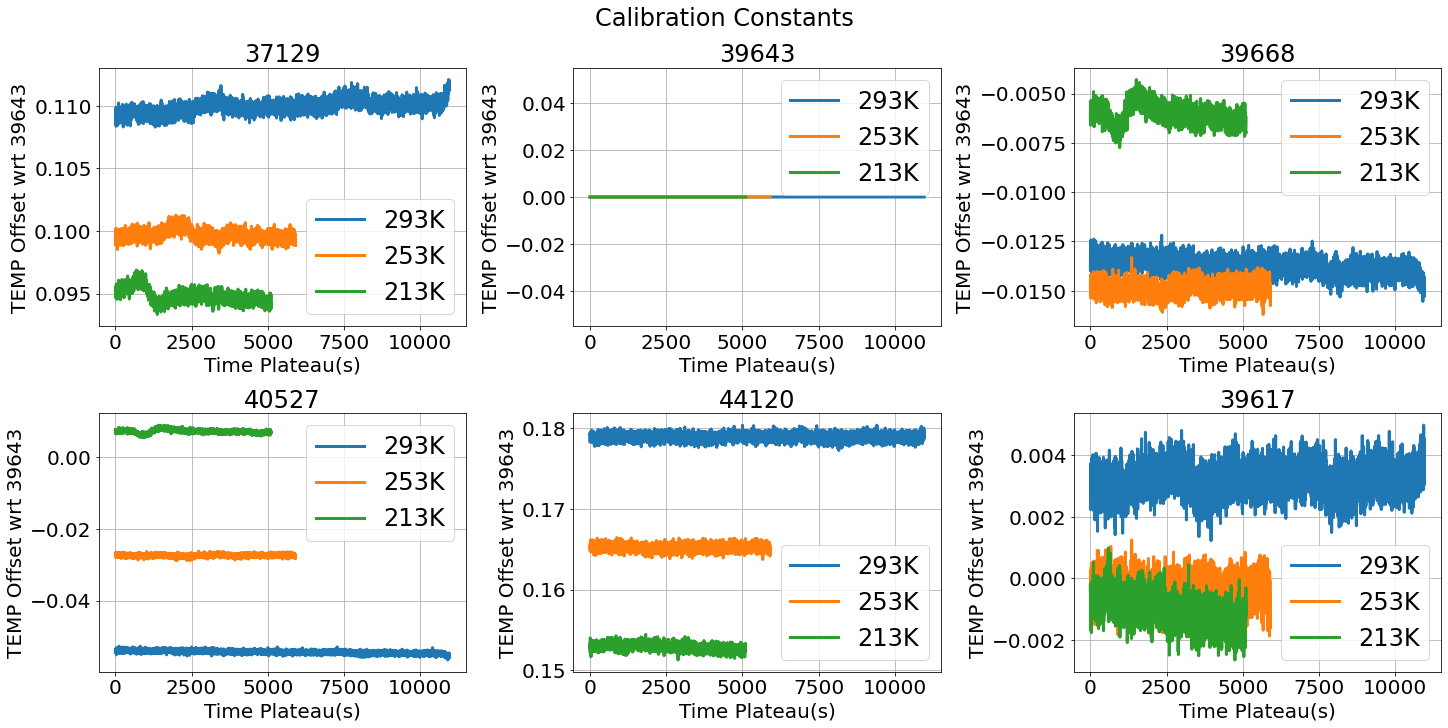

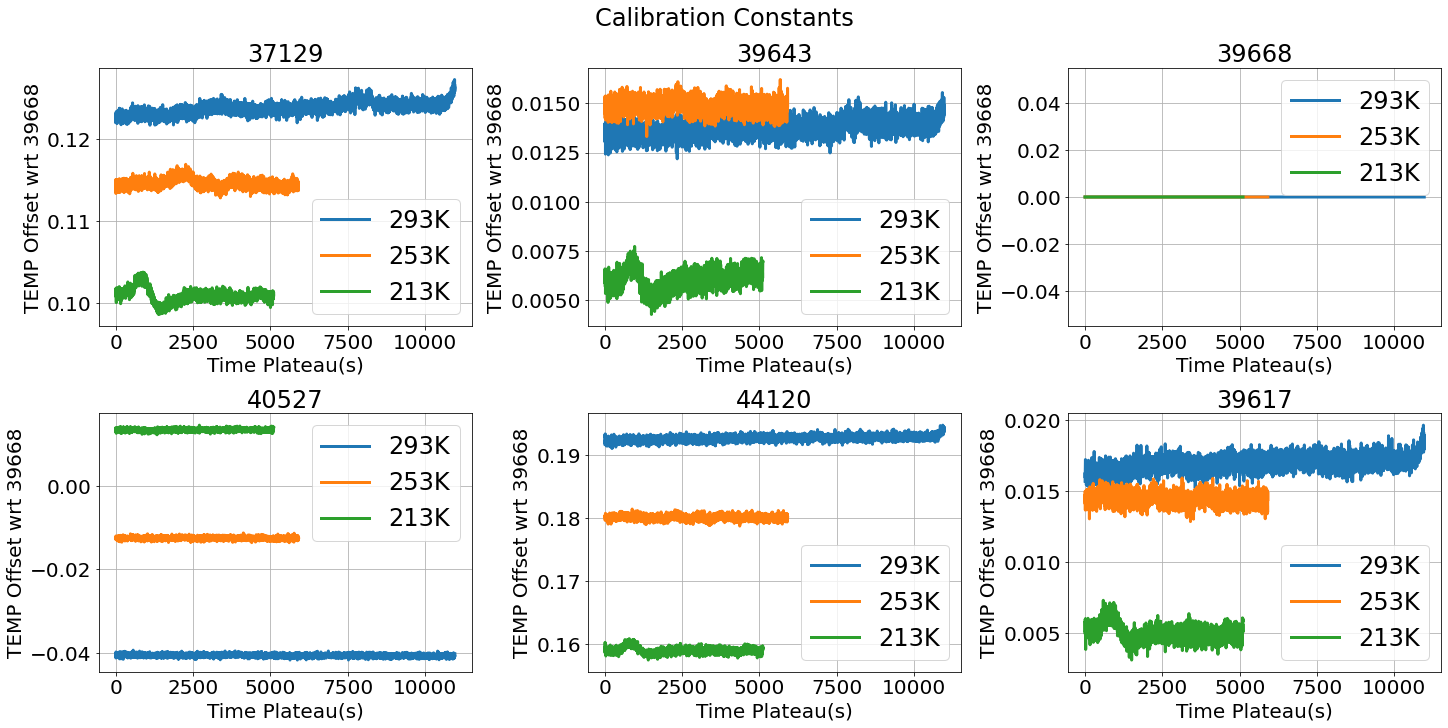

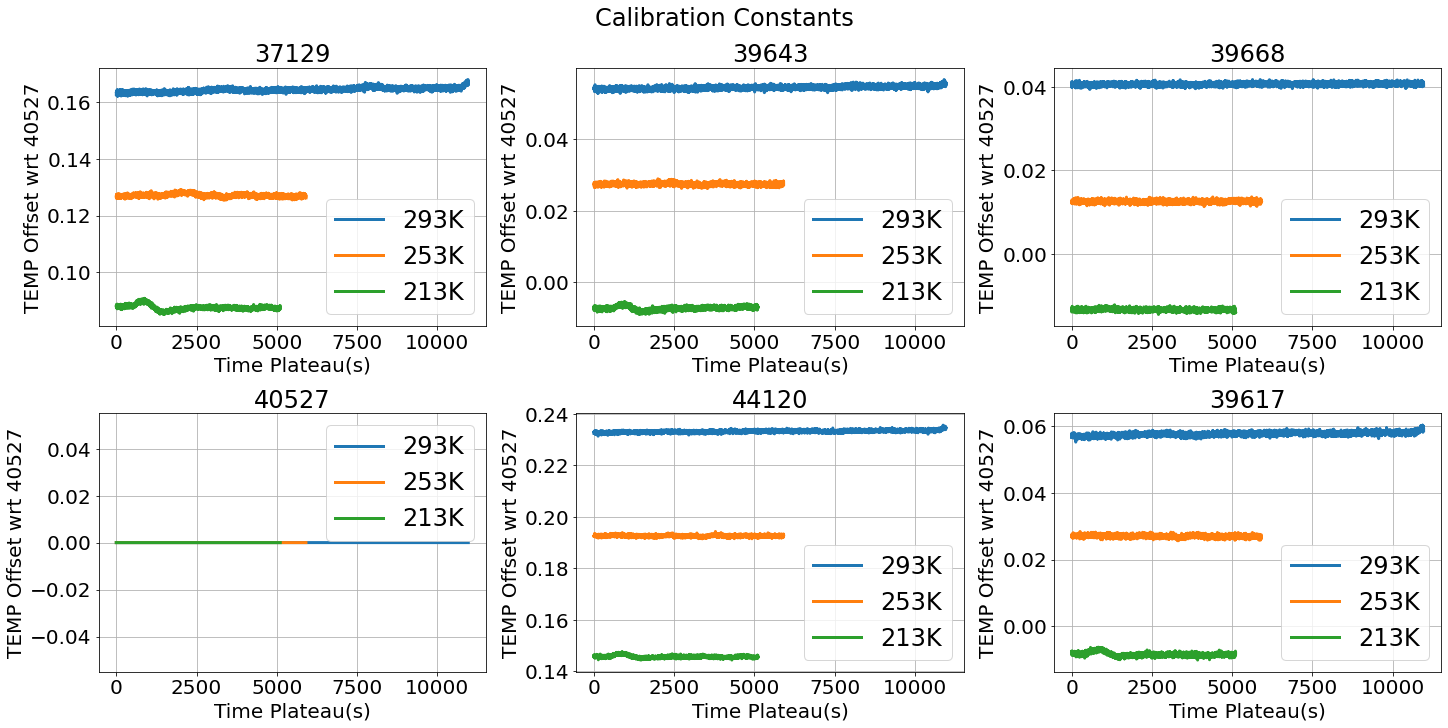

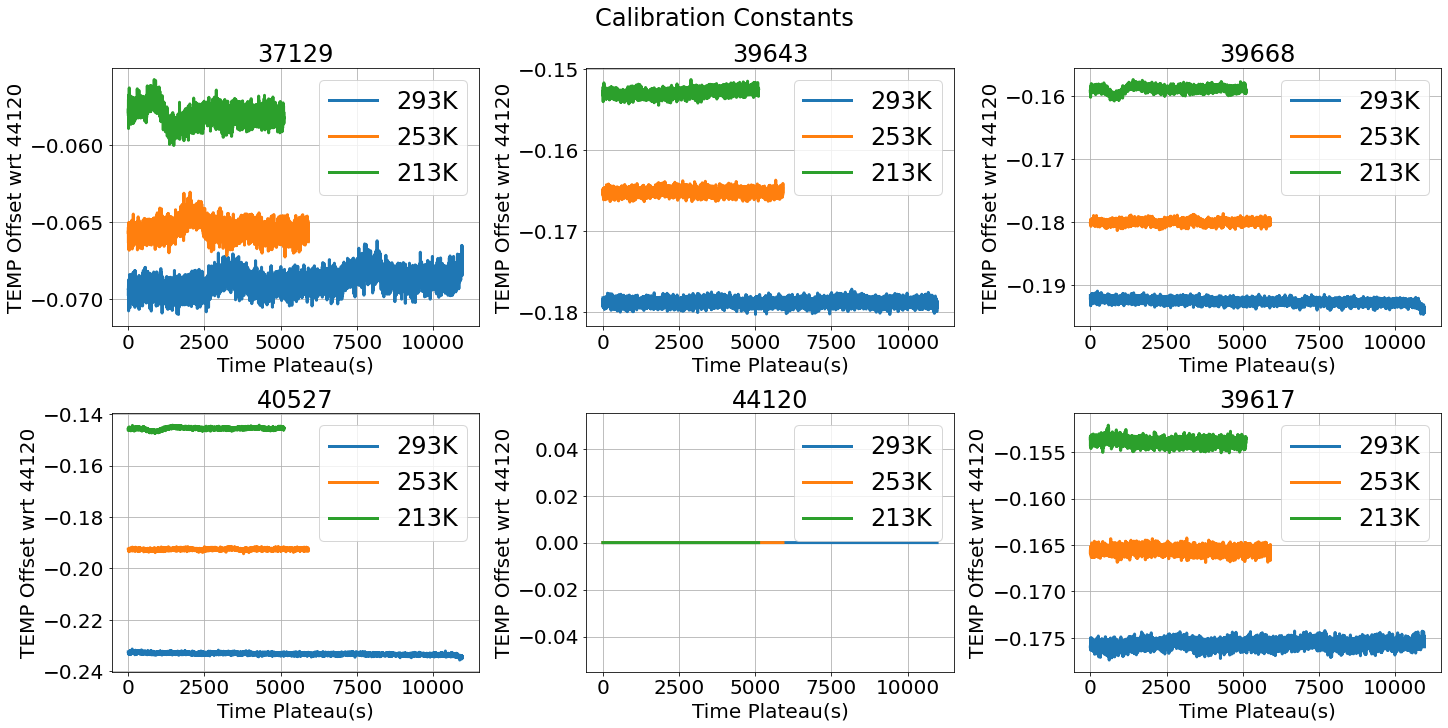

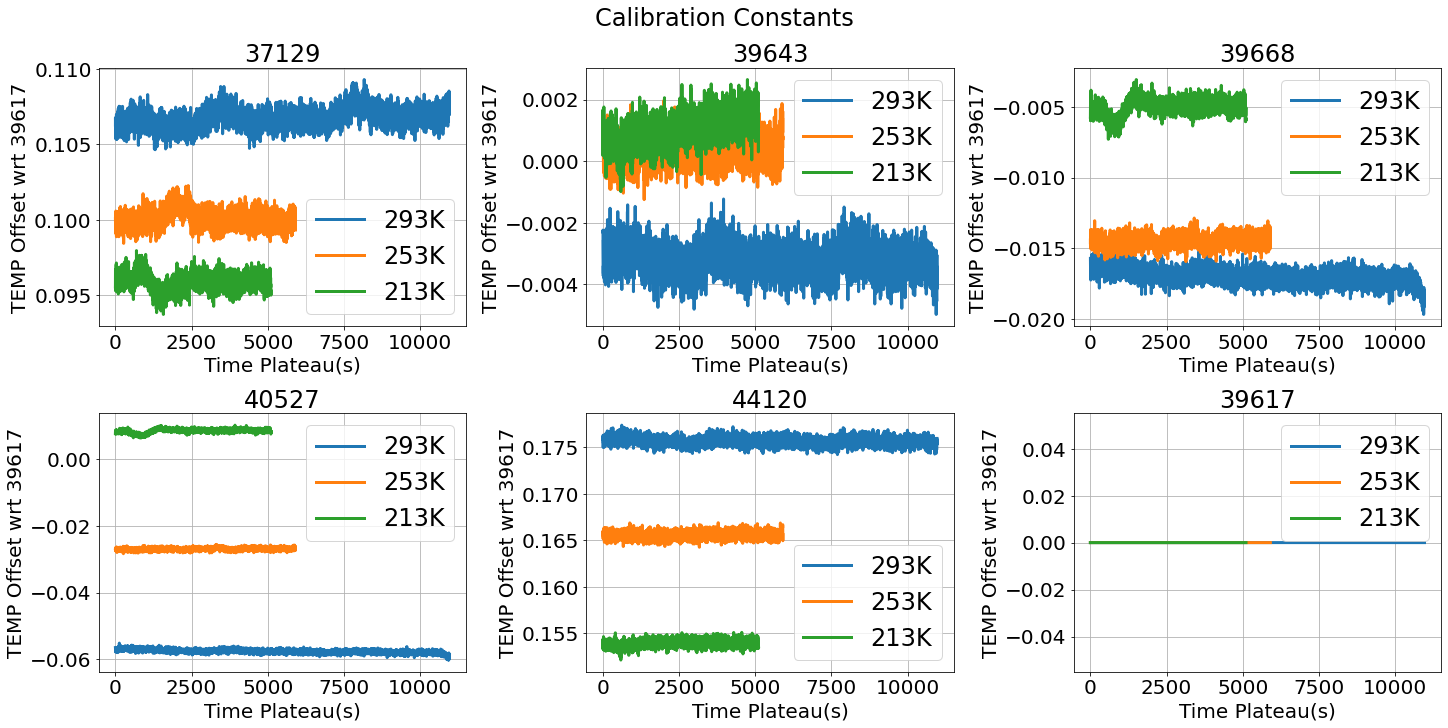

In [8]:
cc = {}
cc_err = {}
for ref in rtds.columns:
    if ref == "Timestamp" or ref == "Time" or ref == "Date":
        continue
    cc[ids[ref]] = {}
    cc_err[ids[ref]] = {}
    for sens in rtds.columns:
        if sens == "Timestamp" or sens == "Time" or sens == "Date":
            continue
        cc[ids[ref]][ids[sens]] = {}
        cc_err[ids[ref]][ids[sens]] = {}
    

for ref in rtds.columns:
    if ref == "Timestamp" or ref == "Time" or ref == "Date":
        continue
    fig, axes = graphic_tools.make_figure(nrows=2, ncols=3)
    fig.set_size_inches((20,10))
    fig.suptitle("Calibration Constants")
    for plateau in plateaus[date].keys():
        t0 = plateaus[date][plateau][0] + 1e4
        tf = plateaus[date][plateau][1] - 100
        tcut = rtds.loc[(rtds["Timestamp"]>t0) & (rtds["Timestamp"]<tf)]
        cnt = 0
        for sens in tcut.columns:
            if sens == "Timestamp" or sens == "Time" or sens == "Date":
                continue
            axes[cnt].plot(tcut["Timestamp"]-t0, tcut[sens]-tcut[ref], label=plateau.split("_")[0]+"K")
            axes[cnt].set_title(ids[sens])
            axes[cnt].set_xlabel("Time Plateau(s)")
            axes[cnt].set_ylabel("TEMP Offset wrt " + ids[ref])
            axes[cnt].legend()
            cc[ids[ref]][ids[sens]][plateau] = np.mean(tcut[sens]-tcut[ref])
            cc_err[ids[ref]][ids[sens]][plateau] = np.std(tcut[sens]-tcut[ref])
            cnt += 1
    fig.show()

In [9]:
from scipy.optimize import curve_fit
def line(x, A, B):
    return A + B*x

for ref in cc.keys():
    for sens in cc[ref].keys():
        popt, pcov = curve_fit(line, xdata=[293., 253., 213.], ydata=list(cc[ref][sens].values()))
        cc[ref][sens] = list(popt)

In [10]:
print(cc)

{'37129': {'37129': [0.0, 0.0], '39643': [-0.05355979725765988, -0.000189489322329003], '39668': [-0.04074641175475156, -0.00028580745503842617], '40527': [0.11661518527942978, -0.0009602743818721243], '44120': [0.02993648529178848, 0.00013517573028700314], '39617': [-0.06637272921883534, -0.00013650204590658226]}, '39643': {'37129': [0.05355979725765989, 0.00018948932232900297], '39643': [0.0, 0.0], '39668': [0.012813384995504317, -9.63181307038738e-05], '40527': [0.17017498259625927, -0.0007707850597769933], '44120': [0.08349628239429051, 0.00032466505322927827], '39617': [-0.012812932180693556, 5.2987277290081216e-05]}, '39668': {'37129': [0.04074641175475155, 0.0002858074550384263], '39643': [-0.012813384995504305, 9.631813070387376e-05], '39668': [0.0, 0.0], '40527': [0.15736159728625312, -0.0006744669278300293], '44120': [0.07068289687599166, 0.00042098318599953364], '39617': [-0.02562631749069969, 0.0001493054092370452]}, '40527': {'37129': [-0.11661518527942977, 0.0009602743818

In [12]:
cc = getters.get_rtdcal()

/afs/cern.ch/user/j/jcapotor/FBG_TMS
/afs/cern.ch/user/j/jcapotor/FBG_TMS/ana_tools/rtd_calib.json


In [13]:
print(cc)

{'37129': {'37129': [0.0, 0.0], '39643': [-0.05355979725765988, -0.000189489322329003], '39668': [-0.04074641175475156, -0.00028580745503842617], '40527': [0.11661518527942978, -0.0009602743818721243], '44120': [0.02993648529178848, 0.00013517573028700314], '39617': [-0.06637272921883534, -0.00013650204590658226]}, '39643': {'37129': [0.05355979725765989, 0.00018948932232900297], '39643': [0.0, 0.0], '39668': [0.012813384995504317, -9.63181307038738e-05], '40527': [0.17017498259625927, -0.0007707850597769933], '44120': [0.08349628239429051, 0.00032466505322927827], '39617': [-0.012812932180693556, 5.2987277290081216e-05]}, '39668': {'37129': [0.04074641175475155, 0.0002858074550384263], '39643': [-0.012813384995504305, 9.631813070387376e-05], '39668': [0.0, 0.0], '40527': [0.15736159728625312, -0.0006744669278300293], '44120': [0.07068289687599166, 0.00042098318599953364], '39617': [-0.02562631749069969, 0.0001493054092370452]}, '40527': {'37129': [-0.11661518527942977, 0.0009602743818